In [97]:
import numpy as np
from quadratures import get_lebedev
from tools_old import project_density, plot_density_projections
from tools import interpolate_density, cartesian_to_spherical_angles, get_basis_poly, get_basis_poly_incorrect
import qe_density_reader.reader as qer
from os.path import join as pjoin   

ImportError: cannot import name 'get_basis_poly_incorrect' from 'tools' (/rds/project/rds-PDSVOqhVGhM/src/qe_density/tools.py)

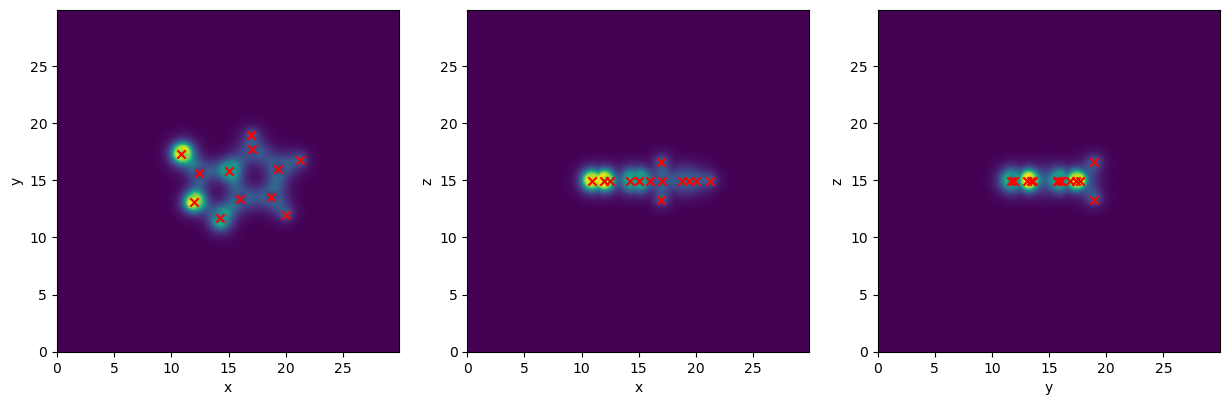

In [2]:
# Load and plot data
DIRPATH = "/home/sp2120/rds/rds-pdb_dist-PDSVOqhVGhM/data/qm9/dsgdb9nsd_atom15_out"
dens = qer.Density(pjoin(DIRPATH, "dsgdb9nsd_130767.hdf5"))

fig, ax = plot_density_projections(project_density(dens.rho), dens.atoms_positions, dens.alat)
# ax[2].set_ylim(10, 20)
# ax[2].set_xlim(10, 20)

## Interpolation
We can test out our interpolation method. Right now we only use linear interpolation but in the future we can use something like cubic or rbf interpolation.

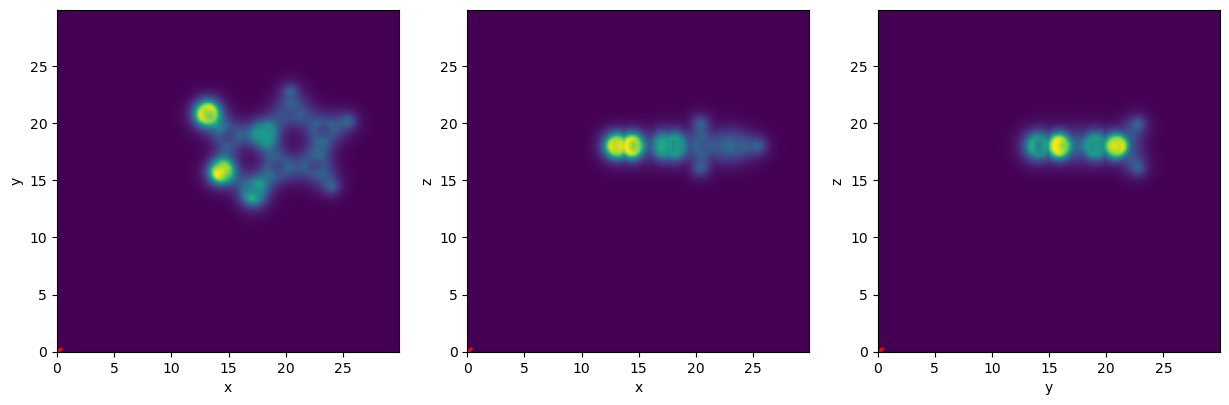

In [53]:
# Test out interpolation
coords2 = dens.get_coords() / 1.2
rho2 = interpolate_density(dens.get_coords(), dens.rho, coords2, method="linear")
ax = plot_density_projections(project_density(rho2), dens.atoms_positions * 0, dens.alat)

# Least squares fitting

In [3]:
from grid.utils import generate_real_spherical_harmonics as grsh
from tools_old import get_density_feats

In [20]:
?grsh

Signature: grsh(l_max: int, theta: numpy.ndarray, phi: numpy.ndarray)
Docstring:
Compute the real spherical harmonics recursively up to a maximum angular degree l.

.. math::
    Y_l^m(\theta, \phi) = \frac{(2l + 1) (l - m)!}{4\pi (l + m)!} f(m, \theta)
    P_l^m(\cos(\phi)),

where :math:`l` is the angular degree, :math:`m` is the order and
:math:`f(m, \theta) = \sqrt{2} \cos(m \theta)` when :math:`m>0` otherwise
:math:`f(m, \theta) = \sqrt{2} \sin(m\theta)`
when :math:`m<0`, and equal to one when :math:`m= 0`.  :math:`P_l^m` is the associated
Legendre polynomial without the Conway phase factor.
The angle :math:`\theta \in [0, 2\pi]` is the azimuthal angle and :math:`\phi \in [0, \pi]`
is the polar angle.

Parameters
----------
l_max : int
    Largest angular degree of the spherical harmonics.
theta : np.ndarray(N,)
    Azimuthal angle :math:`\theta \in [0, 2\pi]` that are being evaluated on.
    If this angle is outside of bounds, then periodicity is used.
phi : np.ndarray(N,)
    Po

In [5]:
rho, atoms_positions, coords = get_density_feats(dens)

In [6]:
centred_coords = coords - atoms_positions[:, None, None, None]

In [9]:
centred_coords.shape

(13, 180, 180, 180, 3)

(172303200,)

In [ ]:
r_cut = 7

for ap in atoms_positions:
    centred_coords = coords - ap
    r, theta, phi = spherical_to_cartesian(centred_coords)
    mask = r < r_cut
    r = r[mask]

In [153]:
r_cut = 5
n_max = 11
l_max = 10

ap = atoms_positions[0]

centred_coords = coords - ap
r = np.linalg.norm(centred_coords, axis=-1)
mask = r < r_cut
r = r[mask]
rho_vals = rho[mask]
theta, phi = cartesian_to_spherical_angles(*centred_coords[mask].T, r)
sh_vals = grsh(l_max, theta, phi)
poly_basis = get_basis_poly(r_cut=r_cut, n_max=n_max, rx=r)
factors = np.einsum("ik,jk->ijk", poly_basis, sh_vals).reshape(n_max * (l_max + 1) ** 2, -1)

# compute coefficients using least squares
coeffs, residuals, rank, s = lstsq(factors.T, rho_vals)

In [142]:
tst.shape

(180, 180, 180)

In [143]:
dens.rho.shape

(180, 180, 180)

In [145]:
project_density(tst)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [149]:
(factors.T @ coeffs).shape

(24635,)

In [ ]:
fig, ax = plot_density_projections(project_density(tst), dens.atoms_positions * 0, dens.alat)

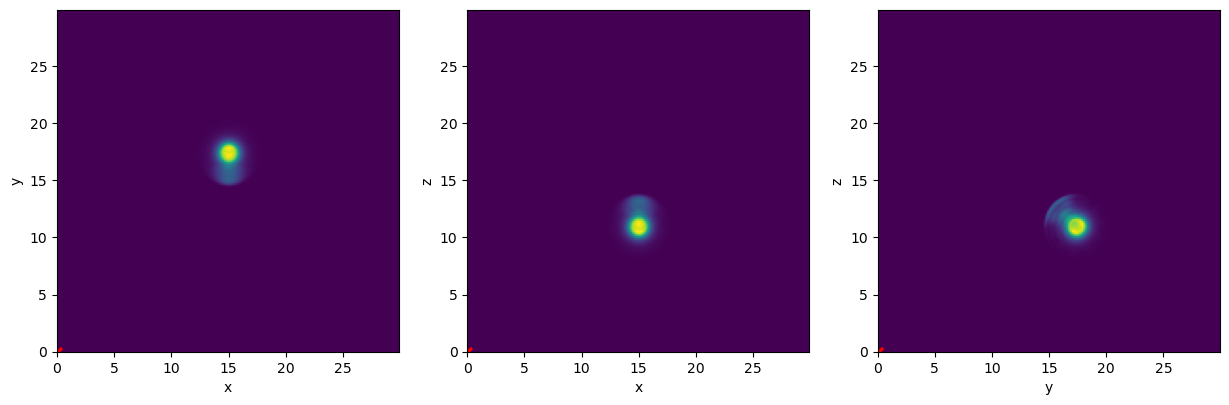

In [150]:
tst = np.zeros_like(rho)
tst[mask] = factors.T @ coeffs

fig, ax = plot_density_projections(project_density(tst), dens.atoms_positions * 0, dens.alat)

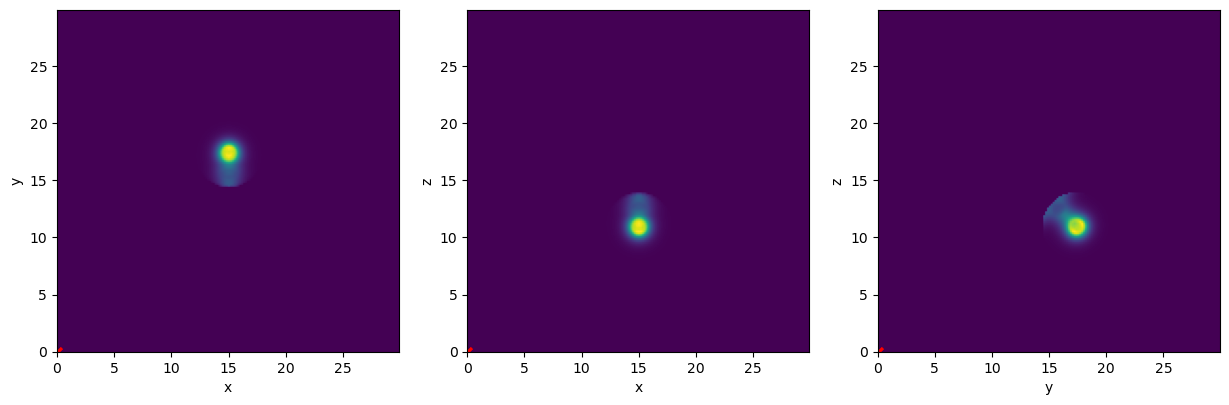

In [152]:
window_rho = np.zeros_like(rho)
window_rho[mask] = rho[mask]

fig, ax = plot_density_projections(project_density(window_rho), dens.atoms_positions * 0, dens.alat)

In [139]:
poly_basis = get_basis_poly(r_cut=r_cut, n_max=n_max, rx=r.flatten()).reshape((n_max, 180 **2))
factors = np.einsum("ik,jk->ijk", poly_basis, sh_vals).reshape(n_max * (l_max + 1) ** 2, -1)

# compute coefficients using least squares
coeffs, residuals, rank, s = lstsq(factors.T, rho_vals)

ValueError: cannot reshape array of size 64152000 into shape (11,32400)

In [132]:
r.flat

(180, 180, 180)

In [125]:
centred_coords.shape

(180, 180, 180, 3)

In [65]:
from scipy.linalg import lstsq

In [75]:
factors.shape

(294, 313202)

In [76]:
coeffs.shape

(294,)

In [121]:
approx_rho = (factors.T @ coeffs)

# print summary statistics of the error
print("Mean error: ", np.mean(np.abs(approx_rho - rho_vals)))
print("Max error: ", np.max(np.abs(approx_rho - rho_vals)))
print("Min error: ", np.min(np.abs(approx_rho - rho_vals)))
print("std error: ", np.std(np.abs(approx_rho - rho_vals)))

Mean error:  0.005623306676588774988
Max error:  0.3126775001007030054
Min error:  3.8732629467619610758e-08
std error:  0.01832992862060988083


In [109]:
approx_rho = (factors.T @ coeffs)

# print summary statistics of the error
print("Mean error: ", np.mean(np.abs(approx_rho - rho_vals)))
print("Max error: ", np.max(np.abs(approx_rho - rho_vals)))
print("Min error: ", np.min(np.abs(approx_rho - rho_vals)))
print("std error: ", np.std(np.abs(approx_rho - rho_vals)))

Mean error:  0.033479810418198279403
Max error:  0.51339229384307973015
Min error:  5.732712082817670307e-10
std error:  0.078389383226171835634


In [94]:
approx_rho = (factors.T @ coeffs)

# print summary statistics of the error
print("Mean error: ", np.mean(np.abs(approx_rho - rho_vals)))
print("Max error: ", np.max(np.abs(approx_rho - rho_vals)))
print("Min error: ", np.min(np.abs(approx_rho - rho_vals)))
print("std error: ", np.std(np.abs(approx_rho - rho_vals)))

Mean error:  0.012640371438434813078
Max error:  0.6659320674569389131
Min error:  1.2045854417738629317e-16
std error:  0.027876048205804540183


In [89]:
approx_rho = (factors.T @ coeffs)

# print summary statistics of the error
print("Mean error: ", np.mean(np.abs(approx_rho - rho_vals)))
print("Max error: ", np.max(np.abs(approx_rho - rho_vals)))
print("Min error: ", np.min(np.abs(approx_rho - rho_vals)))
print("std error: ", np.std(np.abs(approx_rho - rho_vals)))

Mean error:  0.017420506994121124782
Max error:  0.6659668839483898067
Min error:  3.0024286640814462144e-17
std error:  0.037139451510866020285


In [44]:
get_basis_poly(7, n_max=6, rx=r)

ValueError: operands could not be broadcast together with shapes (6,313202) (6,49,313202) 

In [81]:
approx_rho - rho_vals

array([ 2.79769254e-12,  7.93412010e-08,  7.47401688e-07, ...,
       -1.55956609e-01, -1.56337134e-01, -1.56871119e-01], dtype=float128)

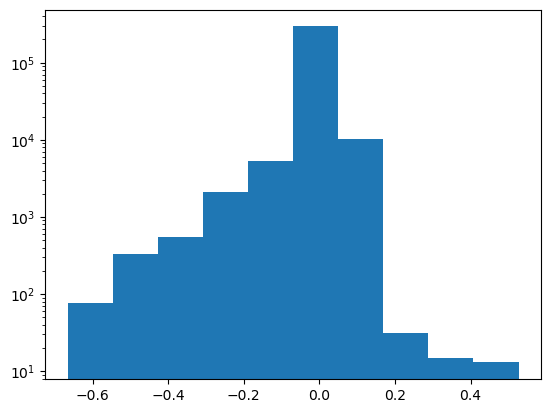

In [87]:
plt.hist(approx_rho - rho_vals)
plt.yscale("log")

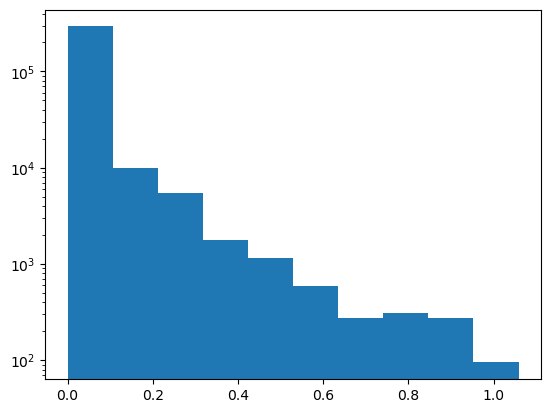

In [86]:
plt.hist(rho_vals)
plt.yscale("log")

In [28]:
# DSCRIBE uses eight radial basis functions and six spherical harmonics
sh_vals.shape

(49, 313202)

In [38]:
poly_basis.shape

(6, 313202)

In [39]:
sh_vals.shape

(49, 313202)

In [19]:
theta.shape

(313202,)

In [11]:
r = np.linalg.norm(centred_coords, axis=-1).shape

In [36]:
np.transpose(centred_coords, (3, 0, 1, 2))[:, 1, 2, 3]

array([-10.71900708, -16.97813275, -14.45579006])

In [12]:
r

(180, 180, 180)

In [22]:
centred_coords.T.shape

(3, 180, 180, 180)

In [26]:
centred_coords[1, 0, 0, :]

array([-10.71900708, -17.31045368, -14.95427145])